# E2a: Küchentischversuch zum Laval-Rotor

Name: Tim Rehberger
Datum: 21.12.2023

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: 

Messung der Beschleunigung an Haushaltsgegenständen mit rotierenden Komponenten und anschließender Fouriertransformation um die hervorstechenden Frequenzen zu ermitteln.

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann dann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

<img src="Probe1.jpeg" width="924">

- Beschreibung des Aufbaus: Messung beim Hula Hoop
- Vorgangsbeschreibung: Befestigung des Sensors am Bein

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [34]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [35]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "./measurement_data/data_20240110_152754_Tim_Rehberger_hoop"# replace None by the relative path to the first object's folder
h5_file_name = "data_20240110_152754_Tim_Rehberger_hoop.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [36]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "./measurement_data/data_20240110_152754_Tim_Rehberger_hoop/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "./measurement_data/data_20240110_152754_Tim_Rehberger_hoop/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "./measurement_data/data_20240110_152754_Tim_Rehberger_hoop/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeafb8e-fb8c-6a96-8b5a-81081ba708c2": {
    "type": "probe",
    "name": "hoop",
    "comment": "",
    "path": "./measurement_data

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [37]:
with h5py.File("{}/{}".format(path_measurement_folder, h5_file_name), "r") as file:
    key1 = list(file.keys())[0]
    uuid = list(file[key1].keys())[0]
    
    acceleration_x = np.array(file[key1][uuid]["acceleration_x"])
    acceleration_y = np.array(file[key1][uuid]["acceleration_y"])
    acceleration_z = np.array(file[key1][uuid]["acceleration_z"])
    timestamp = np.array(file[key1][uuid]["timestamp"])    

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [38]:
values = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
print(values)
print(timestamp)

[ 9.55028756  9.55028756 10.12578284 ... 10.96255397 10.16445908
 10.16445908]
[2.69150734e-03 1.02586746e-02 1.56509876e-02 ... 1.99937842e+01
 1.99968445e+01 2.00001850e+01]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

In [39]:
fig1, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(timestamp, values)

ax1.set_ylabel("acceleration in m/s²")
ax1.set_xlabel("time in s")

# Calculate the time difference between each measurement

time_diff = [0]
i = 1
n = len(timestamp)

while i < n:
    time_diff.append(timestamp[i] - timestamp[i - 1])
    i += 1
    
ax2.plot(timestamp, time_diff)
    

#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

[2.69150734e-03 5.97301267e-03 9.25451801e-03 ... 1.99936220e+01
 1.99969035e+01 2.00001850e+01]
[ 9.55028756  9.55028756  9.55028756 ... 10.96255397 10.16445908
 10.16445908]


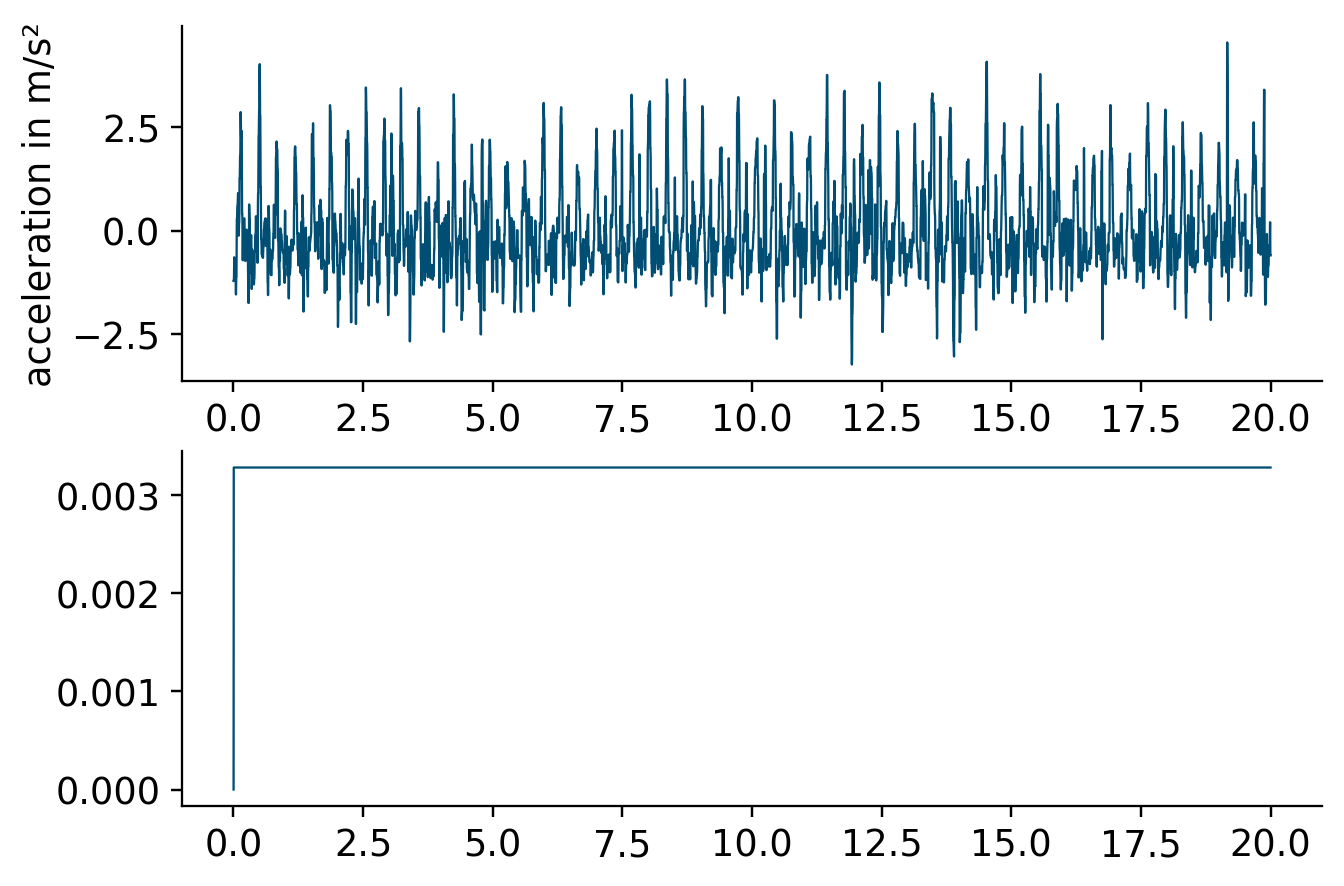

In [40]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.

new_time , new_values = interpolation(timestamp, values)

print(new_time)
print(new_values)

#remove offset to exclude a huge freqency peak at 0 Hz

meanvalue = np.mean(new_values)
new_values = new_values - meanvalue


fig2, (ax3, ax4) = plt.subplots(2,1)
ax3.plot(new_time, new_values)
ax3.set_ylabel("acceleration in m/s²")
ax3.set_xlabel("time in s")


# Calculate the time difference for the interpolated measurements

time_diff = [0]
i = 1
n = len(new_time)

while i < n:
    time_diff.append(new_time[i] - new_time[i - 1])
    i += 1
    
ax4.plot(new_time, time_diff)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

In [41]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.

amp, freq = my_fft(new_values, new_time)

fig3, ax5 = plt.subplots(1,1)
ax5.plot(freq, np.abs(amp))
ax5.set_ylabel("FFT amplitude")
ax5.set_xlabel("frequency in Hz")
ax5.set_xlim(0,10)
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

(0.0, 10.0)

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:


- Beschreibung des Aufbaus:
- Vorgangsbeschreibung:

## Versuchsauswertung

Führen Sie die obige Auswertung für den zweiten Gegenstand durch. Sie brauchen dafür nichts neu zu implementieren.

#### 1a. Einlesen der Mess- und Metadaten

In [42]:
"""Parameter definition"""

path_measurement_folder = "./measurement_data/data_20240112_092546_Tim_Rehberger_phone"# replace None by the relative path to the first object's folder
h5_file_name = "data_20240112_092546_Tim_Rehberger_phone.h5" # replace None by the filename of the hdf5-file

"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "./measurement_data/data_20240112_092546_Tim_Rehberger_phone/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "./measurement_data/data_20240112_092546_Tim_Rehberger_phone/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "./measurement_data/data_20240112_092546_Tim_Rehberger_phone/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1eeb1231-cb79-6484-aa9b-1b8373b9732b": {
    "type": "probe",
    "name": "phone",
    "comment": "",
    "path": "./measurement_

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [43]:
with h5py.File("{}/{}".format(path_measurement_folder, h5_file_name), "r") as file:
    key1 = list(file.keys())[0]
    uuid = list(file[key1].keys())[0]
    
    acceleration_x = np.array(file[key1][uuid]["acceleration_x"])
    acceleration_y = np.array(file[key1][uuid]["acceleration_y"])
    acceleration_z = np.array(file[key1][uuid]["acceleration_z"])
    timestamp = np.array(file[key1][uuid]["timestamp"])   

#### 2. Betrag der Beschleunigung berechnen


In [44]:
values = get_vec_accel(acceleration_x, acceleration_y, acceleration_z)

#### 3. Darstellung der Messdaten

In [45]:
fig21, (ax21, ax22) = plt.subplots(2,1)
ax21.plot(timestamp, values)

ax21.set_ylabel("acceleration in m/s²")
ax21.set_xlabel("time in s")

# Calculate the time difference between each measurement

time_diff = [0]
i = 1
n = len(timestamp)

while i < n:
    time_diff.append(timestamp[i] - timestamp[i - 1])
    i += 1
    
ax22.plot(timestamp, time_diff)

#### 4. Interpolation der Messwerte



In [46]:
new_time , new_values = interpolation(timestamp, values)

#remove offset to exclude a huge freqency peak at 0 Hz

meanvalue = np.mean(new_values)
new_values = new_values - meanvalue


fig22, (ax23, ax24) = plt.subplots(2,1)
ax23.plot(new_time, new_values)
ax23.set_ylabel("acceleration in m/s²")
ax23.set_xlabel("time in s")


# Calculate the time difference for the interpolated measurements

time_diff = [0]
i = 1
n = len(new_time)

while i < n:
    time_diff.append(new_time[i] - new_time[i - 1])
    i += 1
    
ax24.plot(new_time, time_diff)

#### 5 & 6. FFT durchführen und graphisch darstellen


In [47]:
amp, freq = my_fft(new_values, new_time)

fig23, ax25 = plt.subplots(1,1)
ax25.plot(freq, np.abs(amp))
ax25.set_ylabel("FFT amplitude")
ax25.set_xlabel("frequency in Hz")
ax25.set_xlim(0,10)

(0.0, 10.0)

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Die Auswertung der ersten Messung zeigt deutlich 4 Frequenzausschläge bei etwa 1,8Hz , 3,2Hz , 4,9Hz , 6,2Hz.

Dabei ist der größte Auschlag bei 3,2Hz. Dieser wäre für die Umdrehungsrate des Hula Hoop Reifens ein plausibler Wert.
Bei dem Wert von 1,8Hz könnte es sich um ein Vielfaches der Umdrehungsrate handeln, vielleicht durch unbewusste Korrekturen oder Änderung der Körperposition.

Die beiden größeren Werte bei 4,9Hz und 6,2Hz mit deutlich kleineren Ausschlägen könnte es sich um die Eigenschwingungen der Sensoranbringung handeln. Diese bestand aus Doppelseitigem Klebeband, welches sich etwas von der Haut gelöst hat und somit mit dem Sensor ein zusätzlich schwingendes System ergibt.


Bei der zweiten Messung ist ein undeutlicherer Ausschlag bei etwa 3Hz zu erkennen. Jedoch wären 3Hz für die Vibration bei einem Handy eine zu niedrige Frequenz. Da sonst keine großen Ausschläge bei höheren Frequenzen zu erkennen sind, könnte es sich hier um einen Fall von Aliasing handeln. Dabei werden hohe Frequenzen bei der Messung als niedrigere Frequenzen wahrgenommen, wenn die Abtastrate des Sensors zu gering ist.

Es gibt zusätzlich noch einen Ausschlag bei etwa 0,5Hz. Dieser wird wahrscheinlich dadurch verursacht, dass die Vibration etwa alle 2 Sekunden kurz stoppt.


## Fazit
In diesem Versuch konnte ich eigene Methoden zur Lösung der gegebenen Probleme entwickeln und mein Verstnändnis zur Fourier Transformation wiederauffrischen.